In [1]:
from openai import OpenAI
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import numpy as np
import os

# Initialize client with new syntax
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

# Check it's set
if client.api_key is None:
    raise ValueError("OPENAI_API_KEY environment variable not set!")
else:
    print("✓ API key loaded from environment")
    print(f"✓ Key starts with: {client.api_key[:8]}...")
print("Setup complete!")

✓ API key loaded from environment
✓ Key starts with: sk-proj-...
Setup complete!


In [2]:
# Load the ASAP short answer dataset (TSV format)
df = pd.read_csv('train_rel_2.tsv', sep='\t')

# Basic info
print(f"Total responses: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few column names:")
for col in df.columns[:10]:
    print(f"  - {col}")

# See the first row to understand structure
print(f"\n{'='*50}")
print(f"FIRST ROW (to understand data structure):")
print(f"{'='*50}")
print(df.iloc[0])

Total responses: 17043

Columns: ['Id', 'EssaySet', 'Score1', 'Score2', 'EssayText']

First few column names:
  - Id
  - EssaySet
  - Score1
  - Score2
  - EssayText

FIRST ROW (to understand data structure):
Id                                                           1
EssaySet                                                     1
Score1                                                       1
Score2                                                       1
EssayText    Some additional information that we would need...
Name: 0, dtype: object


In [3]:
# Focus on Q10
q10 = df[df['EssaySet'] == 10]

print(f"{'='*50}")
print(f"QUESTION 10 DATA")
print(f"{'='*50}")
print(f"Total Q10 responses: {len(q10)}")
print(f"Score range: {q10['Score1'].min()} to {q10['Score1'].max()}")

# Score distribution
print(f"\nScore distribution:")
print(q10['Score1'].value_counts().sort_index())

# Show 3 sample responses (one for each score)
print(f"\n{'='*50}")
print(f"SAMPLE RESPONSES (one per score level):")
print(f"{'='*50}")

for score in sorted(q10['Score1'].unique()):
    sample = q10[q10['Score1'] == score].iloc[0]
    print(f"\n--- Score {score} Example ---")
    print(f"Response: {sample['EssayText'][:200]}...")  # First 200 chars
    print()

QUESTION 10 DATA
Total Q10 responses: 1640
Score range: 0 to 2

Score distribution:
Score1
0    290
1    770
2    580
Name: count, dtype: int64

SAMPLE RESPONSES (one per score level):

--- Score 0 Example ---
Response: light gray ::  The darker of color the , the hoter it g ets...


--- Score 1 Example ---
Response: white :: White because you wouldn't want the dog to ge t to hot....


--- Score 2 Example ---
Response: black :: black might affect the dog house because then the doghouse can get to hot for the dog. iknow this because in the resul ts black got the hottest....



In [4]:
# Official Question 10 information from ReadMeFirst.docx

Q10_GRADE = "8"
Q10_SUBJECT = "Science"

Q10_QUESTION = """Brandi and Jerry did a controlled experiment to find out how the color of an object affects its temperature.

Question: What is the effect of different lid colors on the air temperature inside a glass jar exposed to a lamp?

Hypothesis: The darker the lid color, the greater the increase in air temperature in the glass jar, because darker colors absorb more energy.

They tested four colored lids (black, dark gray, light gray, and white) on glass jars with thermometers, placed a lamp 5 cm away, and measured temperature after 10 minutes for 3 trials each.

Results (Average Temperature):
- Black lid: 53°C
- Dark gray lid: 48°C  
- Light gray lid: 45°C
- White lid: 42°C

Brandi and Jerry were designing a doghouse. Use the results from the experiment to describe the best paint color for the doghouse.

In your description, be sure to:
- Choose a paint color.
- Describe how that color might affect the inside of the doghouse.
- Use results from the experiment to support your description."""

Q10_RUBRIC = """Score 2: Response chooses a color AND describes how that color might affect the inside of the doghouse AND uses results from the experiment to support the description.

Score 1: Response chooses a color and describes how that color might affect the inside of the doghouse BUT the results from the experiment are missing, OR response chooses a color and includes results from the experiment BUT the description of how that color might affect the inside of the doghouse is missing.

Score 0: Response demonstrates little or no understanding. Does not adequately choose a color, describe effects, or use experimental results."""

Q10_SCORE_RANGE = "0-2"

print("✓ Official Q10 information loaded")
print(f"✓ Grade: {Q10_GRADE}")
print(f"✓ Subject: {Q10_SUBJECT}")
print(f"✓ Score range: {Q10_SCORE_RANGE}")

✓ Official Q10 information loaded
✓ Grade: 8
✓ Subject: Science
✓ Score range: 0-2


In [5]:
def create_prompt(student_response):
    """Create prompt for GPT-4 following Paper 2's format"""
    
    prompt = f"""You are a grader for a {Q10_GRADE}-grade {Q10_SUBJECT} exam in a high school. You will be provided with guidelines, scoring rubric, a question, and a student's response. Rate the response according to the scoring rubric. You should reply with rating only.

**Question:**
{Q10_QUESTION}

**Rubric:**
{Q10_RUBRIC}

**Rubric Range:** {Q10_SCORE_RANGE}

**Student Response:**
{student_response}

Score:"""
    
    return prompt

# Test it with the first Q10 response
test_response = q10.iloc[0]
test_prompt = create_prompt(test_response['EssayText'])

print("✓ Prompt function created!")
print(f"\nActual human score for this response: {test_response['Score1']}")
print(f"\n{'='*60}")
print("PREVIEW OF PROMPT (first 800 characters):")
print(f"{'='*60}")
print(test_prompt[:800] + "...")

✓ Prompt function created!

Actual human score for this response: 2

PREVIEW OF PROMPT (first 800 characters):
You are a grader for a 8-grade Science exam in a high school. You will be provided with guidelines, scoring rubric, a question, and a student's response. Rate the response according to the scoring rubric. You should reply with rating only.

**Question:**
Brandi and Jerry did a controlled experiment to find out how the color of an object affects its temperature.

Question: What is the effect of different lid colors on the air temperature inside a glass jar exposed to a lamp?

Hypothesis: The darker the lid color, the greater the increase in air temperature in the glass jar, because darker colors absorb more energy.

They tested four colored lids (black, dark gray, light gray, and white) on glass jars with thermometers, placed a lamp 5 cm away, and measured temperature after 10 minutes for 3...


In [6]:
def score_with_gpt4(prompt):
    """Call GPT-4 to score a response"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        max_tokens=10
    )
    return response.choices[0].message.content

print("✓ GPT-4 scoring function created!")

✓ GPT-4 scoring function created!


In [7]:
import numpy as np
import pandas as pd
import random
import time

# Generate a fresh, truly random seed and record it
SEED = random.randint(1, 999999)
print(f"Testing 100 Q10 responses – EXACT 19-47-34 ratio (Jiang & Bosch)")
print(f"RANDOM DRAW – seed for this run: {SEED}  ← save this to reproduce exactly")

# Stratified sampling with the recorded seed
zeros = q10[q10['Score1'] == 0].sample(n=19, random_state=SEED)
ones  = q10[q10['Score1'] == 1].sample(n=47, random_state=SEED)
twos  = q10[q10['Score1'] == 2].sample(n=34, random_state=SEED)
test_sample = pd.concat([zeros, ones, twos]).sample(frac=1, random_state=SEED)

predictions_official = []
actuals_official = []

for idx, (_, row) in enumerate(test_sample.iterrows(), 1):
    prompt = create_prompt(row['EssayText'])  # NO examples
    pred = score_with_gpt4(prompt) 
    
    try:
        pred_int = int(pred.strip())
    except:
        print(f"Warning: Non-integer '{pred}' → defaulting to 0")
        pred_int = 0
    
    predictions_official.append(pred_int)
    actuals_official.append(row['Score1'])
    
    if idx % 10 == 0:
        print(f"Progress: {idx}/100 scored...")
    
    time.sleep(0.5)

# Metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score
accuracy_official = accuracy_score(actuals_official, predictions_official)
qwk_official = cohen_kappa_score(actuals_official, predictions_official, weights='quadratic')

# Save results for plotting later
results_official_df = test_sample.copy()
results_official_df['gpt4_score'] = predictions_official
results_official_df['human_score'] = actuals_official
results_official_df['correct'] = results_official_df['gpt4_score'] == results_official_df['human_score']
results_official_df['error'] = results_official_df['gpt4_score'] - results_official_df['human_score']

# >>> MINIMAL ADDITIONS FOR PLOTTING <<<
results_official_df['condition'] = 'no_examples'
results_official_df['seed'] = SEED
results_official_df.to_csv(f"no_examples_seed_{SEED}.csv", index=False)
# >>> END MINIMAL ADDITIONS <<<

print(f"\n{'='*70}")
print(f"NO EXAMPLES – random seed {SEED}")
print(f"{'='*70}")
print(f"Accuracy: {accuracy_official:.3f} ({accuracy_official:.1%})")
print(f"QWK:      {qwk_official:.3f}")
print(f"{'='*70}")


Testing 100 Q10 responses – EXACT 19-47-34 ratio (Jiang & Bosch)
RANDOM DRAW – seed for this run: 609159  ← save this to reproduce exactly
Progress: 10/100 scored...
Progress: 20/100 scored...
Progress: 30/100 scored...
Progress: 40/100 scored...
Progress: 50/100 scored...
Progress: 60/100 scored...
Progress: 70/100 scored...
Progress: 80/100 scored...
Progress: 90/100 scored...
Progress: 100/100 scored...

NO EXAMPLES – random seed 609159
Accuracy: 0.710 (71.0%)
QWK:      0.733


In [8]:
def create_prompt_with_official_examples(student_response):
    """Create prompt with official scoring examples from rubric documentation (paper-faithful)"""
    
    prompt = f"""You are a grader for a {Q10_GRADE}-grade {Q10_SUBJECT} exam in a high school. You will be provided with guidelines, scoring rubric, scoring examples, a question, and a student's response. Tables, if there are any, will be in CSV format. Rate the response according to the scoring rubric and scoring examples. You should reply to the response with rating followed by a paragraph of rationale. For the rating, just report a score only.

**Question:**
{Q10_QUESTION}

**Rubric:**
{Q10_RUBRIC}

**Rubric Range:** {Q10_SCORE_RANGE}

**Scoring Examples:**

0 points: "At nite when the dog is trying to sleep, having the paint color as black on the walls to make it darker on the inside of the house, when the dog is trying to sleep."
Notes: Color: Black. Effect on doghouse: At nite when the dog is trying to sleep, having the paint color as black on the walls to make it darker on the inside of the house when the dog is trying to sleep Not connected to the experiment. Results from experiment: None

1 point: "The white color i think will keep the doghouse cooler inside because if it was a dark color then it would conduct the heat and make it warm inside, but since it's white then it will reflect the heat."
Notes: Color: White. Effect on doghouse: ...will keep the doghouse cooler inside... OR ...because if it (the doghouse) was a dark color then it (the doghouse) would conduct the heat and make it (the doghouse) warm inside... Results from experiment: None

2 points: "The black paint will keep the inside of the dog house warm because a dark color will absorb more energy causing the temperature to increase. According to the data from Lid color vs. Air Temperature. Inside Glass jar, the darker the color, the greater the temperature would be inside the dog house."
Note: Color: Black. Effect on doghouse: …will keep the inside of the dog house warm because a dark color will absorb more energy causing the temperature to increase. Results from experiment: …the darker the color, the greater the temperature would be inside the dog house.

**Student Response:**
{student_response}

Score:"""
    
    return prompt

print("✓ Official examples prompt created (paper-faithful)")


✓ Official examples prompt created (paper-faithful)


In [9]:
import time
import re
from sklearn.metrics import accuracy_score, cohen_kappa_score

# CRITICAL: Use the SAME seed as first run
print(f"Testing 100 Q10 responses WITH examples")
print(f"Using SAME seed as first run: {SEED}")
print(f"This ensures fair comparison\n")

# Recreate the SAME test_sample using stratified sampling
zeros = q10[q10['Score1'] == 0].sample(n=19, random_state=SEED)
ones  = q10[q10['Score1'] == 1].sample(n=47, random_state=SEED)
twos  = q10[q10['Score1'] == 2].sample(n=34, random_state=SEED)
test_sample = pd.concat([zeros, ones, twos]).sample(frac=1, random_state=SEED)

predictions_base = []
actuals_base = []

for idx, (_, row) in enumerate(test_sample.iterrows(), 1):
    prompt = create_prompt_with_official_examples(row['EssayText'])  # WITH examples
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            pred = score_with_gpt4(prompt)
            break
        except Exception as e:
            if "rate_limit" in str(e).lower() and attempt < max_retries - 1:
                wait_time = (attempt + 1) * 10
                print(f"Rate limit hit. Waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Error on response {idx}: {e}")
                pred = "0"
                break
    
    try:
        match = re.search(r"Score:\s*([0-2])", str(pred))
        if match:
            pred_int = int(match.group(1))
        else:
            match = re.search(r"\b([0-2])\b", str(pred))
            pred_int = int(match.group(1)) if match else 0
        predictions_base.append(pred_int)
        actuals_base.append(row['Score1'])
        if idx % 10 == 0:
            print(f"Progress: {idx}/100 scored...")
    except Exception as e:
        print(f"Warning: Parsing failed for response {idx}: '{pred}' | {e}")
        predictions_base.append(0)
        actuals_base.append(row['Score1'])
    
    time.sleep(5)

accuracy_base = accuracy_score(actuals_base, predictions_base)
qwk_base = cohen_kappa_score(actuals_base, predictions_base, weights='quadratic')

# Save results for plotting
results_base_df = test_sample.copy()
results_base_df['gpt4_score'] = predictions_base
results_base_df['human_score'] = actuals_base
results_base_df['correct'] = results_base_df['gpt4_score'] == results_base_df['human_score']
results_base_df['error'] = results_base_df['gpt4_score'] - results_base_df['human_score']

# >>> MINIMAL ADDITIONS FOR PLOTTING <<<
results_base_df['condition'] = 'with_examples'
results_base_df['seed'] = SEED
results_base_df.to_csv(f"with_examples_seed_{SEED}.csv", index=False)
# >>> END MINIMAL ADDITIONS <<<

# ===== COMPARISON =====
print(f"\n{'='*70}")
print(f"RESULTS COMPARISON (seed {SEED}):")
print(f"{'='*70}")
print(f"WITH examples (run 2):")
print(f"  Accuracy: {accuracy_base:.3f}")
print(f"  QWK: {qwk_base:.3f}")
print(f"\nNO examples (run 1):")
print(f"  Accuracy: {accuracy_official:.3f}")
print(f"  QWK: {qwk_official:.3f}")
print(f"\nDifference between runs:")
print(f"  Accuracy: {accuracy_base - accuracy_official:+.3f}")
print(f"  QWK: {qwk_base - qwk_official:+.3f}")
print(f"\n{'='*70}")


Testing 100 Q10 responses WITH examples
Using SAME seed as first run: 609159
This ensures fair comparison

Progress: 10/100 scored...
Progress: 20/100 scored...
Progress: 30/100 scored...
Progress: 40/100 scored...
Progress: 50/100 scored...
Progress: 60/100 scored...
Progress: 70/100 scored...
Progress: 80/100 scored...
Progress: 90/100 scored...
Progress: 100/100 scored...

RESULTS COMPARISON (seed 609159):
WITH examples (run 2):
  Accuracy: 0.730
  QWK: 0.750

NO examples (run 1):
  Accuracy: 0.710
  QWK: 0.733

Difference between runs:
  Accuracy: +0.020
  QWK: +0.017



In [10]:
# Analyze GPT-4's mistakes (n=100)
print("ANALYZING GPT-4 ERRORS")
print("="*60)

import pandas as pd
from sklearn.metrics import confusion_matrix

results_df = test_sample.copy()
results_df['gpt4_score'] = predictions_base
results_df['human_score'] = actuals_base
results_df['correct'] = results_df['gpt4_score'] == results_df['human_score']
results_df['error'] = results_df['gpt4_score'] - results_df['human_score']

# Error breakdown
errors = results_df[~results_df['correct']]
print(f"\nTotal errors: {len(errors)}/100")
print(f"GPT-4 too harsh: {len(results_df[results_df['error'] < 0])}")
print(f"GPT-4 too lenient: {len(results_df[results_df['error'] > 0])}")

# Confusion matrix
print("\nCONFUSION MATRIX:")
cm = confusion_matrix(actuals_base, predictions_base, labels=[0, 1, 2])
print("         Predicted")
print("         0   1   2")
for i, label in enumerate([0, 1, 2]):
    print(f"  {label}     {cm[i][0]:3d} {cm[i][1]:3d} {cm[i][2]:3d}")

# Examples of errors
print("\nEXAMPLE ERRORS:")
print("\nToo harsh:")
for idx, row in results_df[results_df['error'] < 0].head(2).iterrows():
    print(f"Human: {row['human_score']}, GPT-4: {row['gpt4_score']}")
    print(f"{row['EssayText'][:150]}...\n")

print("Too lenient:")
for idx, row in results_df[results_df['error'] > 0].head(2).iterrows():
    print(f"Human: {row['human_score']}, GPT-4: {row['gpt4_score']}")
    print(f"{row['EssayText'][:150]}...\n")

ANALYZING GPT-4 ERRORS

Total errors: 27/100
GPT-4 too harsh: 13
GPT-4 too lenient: 14

CONFUSION MATRIX:
         Predicted
         0   1   2
  0      14   5   0
  1       8  30   9
  2       0   5  29

EXAMPLE ERRORS:

Too harsh:
Human: 1, GPT-4: 0
black ::  black because then in the winter when its get s cold whatever sunlight there is it will obsoub the heat and make it sli ghtly warmer...

Human: 1, GPT-4: 0
white :: Cause for each trail and avrage. It is the lo west tepature....

Too lenient:
Human: 1, GPT-4: 2
light gray :: light gray will keep the temperture of the d og house not to hot in the summer and not to cold in the winter. if the d og house was whit...

Human: 1, GPT-4: 2
white ::  The colors affect the temperature of inside t he dog house because darker colors attract more heat than white. I chose white because it has ...



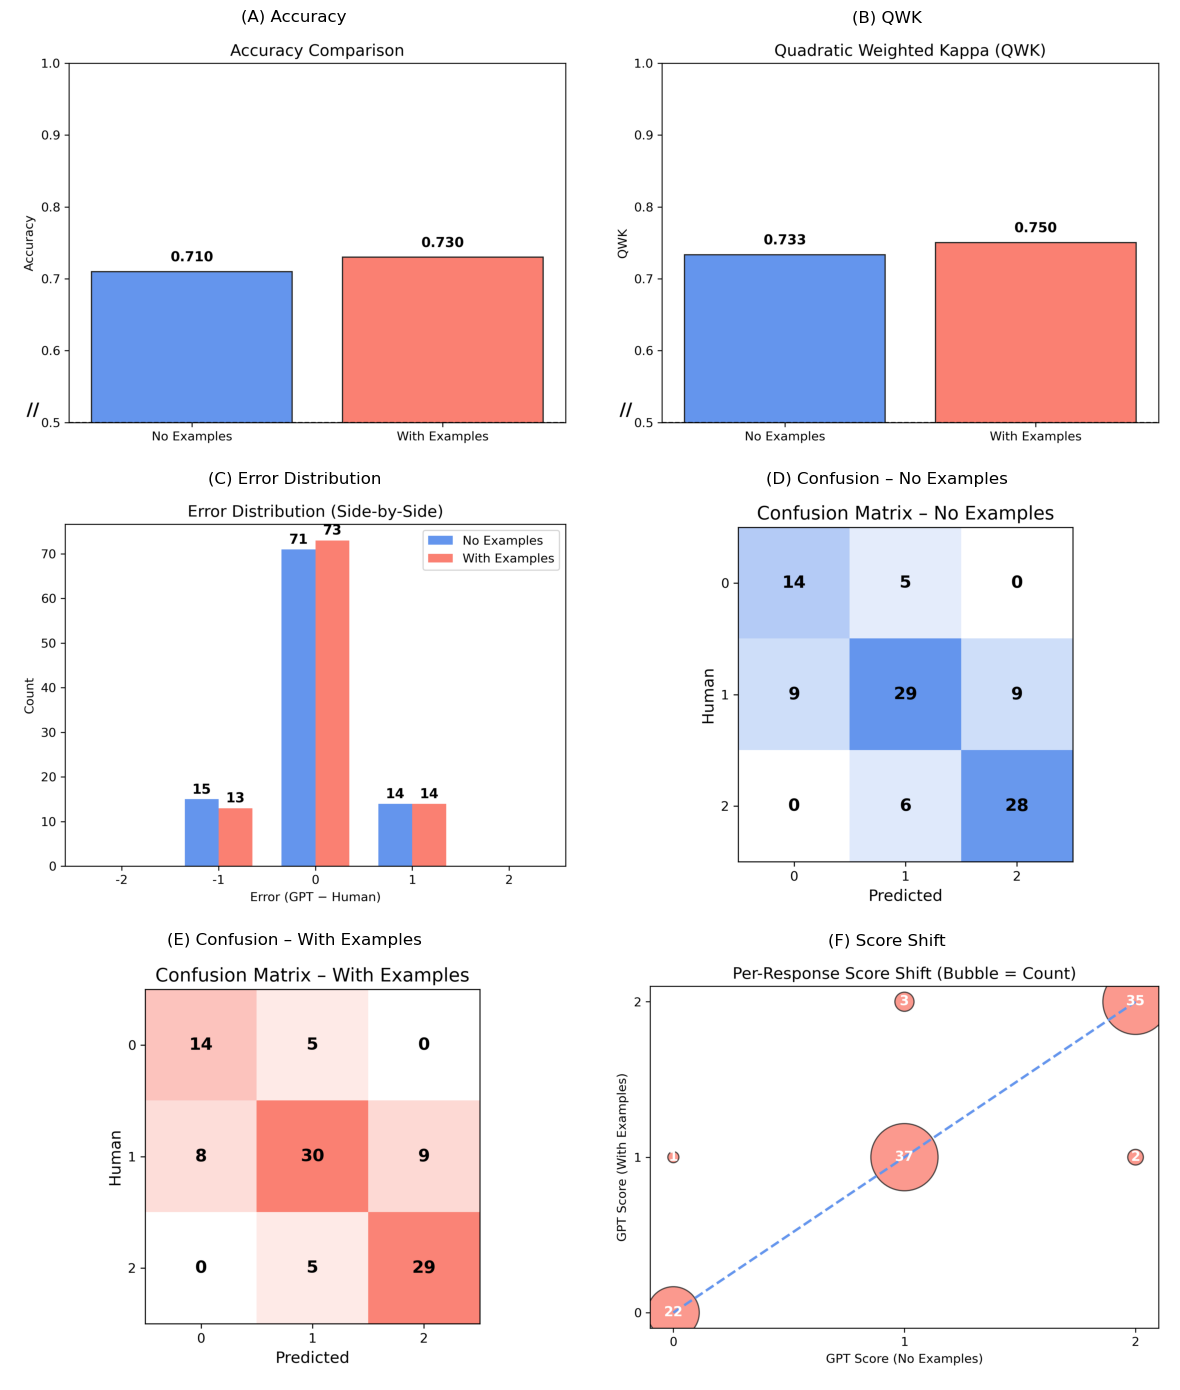

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

# ===============================
# LOAD DATA
# ===============================
df_no  = pd.read_csv(f"no_examples_seed_{SEED}.csv")
df_yes = pd.read_csv(f"with_examples_seed_{SEED}.csv")

# ===============================
# COLORS (Cornflower Blue + Salmon)
# ===============================
blue   = "#6495ED"   # cornflower blue
coral  = "#FA8072"   # salmon
dark   = "#222222"

blue_cmap  = LinearSegmentedColormap.from_list("blue_cmap", ["white", blue])
coral_cmap = LinearSegmentedColormap.from_list("coral_cmap", ["white", coral])

def add_axis_break(ax):
    ax.text(-0.06, 0.01, "//", transform=ax.transAxes,
            fontsize=14, fontweight="bold",
            va="bottom", ha="right")

def label_bars(ax, values):
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom",
                fontsize=11, fontweight="bold")

def label_error_counts(x_positions, counts, offset=0.6):
    for x, c in zip(x_positions, counts):
        if c > 0:
            plt.text(x, c + offset, str(c),
                     ha="center", va="bottom",
                     fontsize=11, fontweight="bold")

# ===============================
# 1. ACCURACY
# ===============================
acc_no  = df_no["correct"].mean()
acc_yes = df_yes["correct"].mean()

fig, ax = plt.subplots()
ax.bar(["No Examples", "With Examples"], [acc_no, acc_yes],
       color=[blue, coral], edgecolor=dark)

ax.set_ylim(0.5, 1.0)
ax.axhline(0.5, linestyle="--", linewidth=1, color="black")
add_axis_break(ax)
label_bars(ax, [acc_no, acc_yes])

ax.set_title("Accuracy Comparison", fontsize=13)
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig(f"accuracy_seed_{SEED}.png", dpi=300)
plt.close()

# ===============================
# 2. QWK
# ===============================
qwk_no  = cohen_kappa_score(df_no["human_score"],  df_no["gpt4_score"],  weights="quadratic")
qwk_yes = cohen_kappa_score(df_yes["human_score"], df_yes["gpt4_score"], weights="quadratic")

fig, ax = plt.subplots()
ax.bar(["No Examples", "With Examples"], [qwk_no, qwk_yes],
       color=[blue, coral], edgecolor=dark)

ax.set_ylim(0.5, 1.0)
ax.axhline(0.5, linestyle="--", linewidth=1, color="black")
add_axis_break(ax)
label_bars(ax, [qwk_no, qwk_yes])

ax.set_title("Quadratic Weighted Kappa (QWK)", fontsize=13)
ax.set_ylabel("QWK")
plt.tight_layout()
plt.savefig(f"qwk_seed_{SEED}.png", dpi=300)
plt.close()

# ===============================
# 3. ERROR DISTRIBUTION (WITH COUNT LABELS)
# ===============================
bins = [-2, -1, 0, 1, 2]
counts_no  = df_no["error"].value_counts().reindex(bins, fill_value=0)
counts_yes = df_yes["error"].value_counts().reindex(bins, fill_value=0)

x = list(range(len(bins)))
width = 0.35
x_no  = [i - width/2 for i in x]
x_yes = [i + width/2 for i in x]

plt.figure()
plt.bar(x_no,  counts_no,  width=width, color=blue,  label="No Examples")
plt.bar(x_yes, counts_yes, width=width, color=coral, label="With Examples")

# Count labels (same style as Accuracy/QWK)
label_error_counts(x_no,  counts_no)
label_error_counts(x_yes, counts_yes)

plt.xticks(x, bins)
plt.xlabel("Error (GPT − Human)")
plt.ylabel("Count")
plt.title("Error Distribution (Side-by-Side)", fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig(f"error_distribution_seed_{SEED}.png", dpi=300)
plt.close()

# ===============================
# 4. CONFUSION MATRIX — NO EXAMPLES
# ===============================
cm_no  = confusion_matrix(df_no["human_score"], df_no["gpt4_score"], labels=[0,1,2])

plt.figure(figsize=(4.5,4.5))
plt.imshow(cm_no, cmap=blue_cmap)
plt.title("Confusion Matrix – No Examples", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Human", fontsize=12)
plt.xticks([0,1,2])
plt.yticks([0,1,2])

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm_no[i, j], ha="center", va="center",
                 fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig(f"confusion_no_seed_{SEED}.png", dpi=300)
plt.close()

# ===============================
# 5. CONFUSION MATRIX — WITH EXAMPLES
# ===============================
cm_yes = confusion_matrix(df_yes["human_score"], df_yes["gpt4_score"], labels=[0,1,2])

plt.figure(figsize=(4.5,4.5))
plt.imshow(cm_yes, cmap=coral_cmap)
plt.title("Confusion Matrix – With Examples", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Human", fontsize=12)
plt.xticks([0,1,2])
plt.yticks([0,1,2])

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm_yes[i, j], ha="center", va="center",
                 fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig(f"confusion_yes_seed_{SEED}.png", dpi=300)
plt.close()

# ===============================
# 6. PER-RESPONSE SCORE SHIFT (BUBBLE COUNTS)
# ===============================
merged = df_no[["Id", "gpt4_score"]].merge(
    df_yes[["Id", "gpt4_score"]],
    on="Id",
    suffixes=("_no", "_yes")
)

pair_counts = (
    merged
    .value_counts(["gpt4_score_no", "gpt4_score_yes"])
    .reset_index(name="count")
)

plt.figure()
sizes = pair_counts["count"] * 80

plt.scatter(
    pair_counts["gpt4_score_no"],
    pair_counts["gpt4_score_yes"],
    s=sizes,
    color=coral,
    edgecolor=dark,
    alpha=0.8
)

plt.plot([0,2], [0,2], linestyle="--", color=blue, linewidth=2)
plt.xticks([0,1,2])
plt.yticks([0,1,2])
plt.xlim(-0.1, 2.1)
plt.ylim(-0.1, 2.1)

for _, r in pair_counts.iterrows():
    plt.text(
        r["gpt4_score_no"],
        r["gpt4_score_yes"],
        str(r["count"]),
        ha="center",
        va="center",
        fontsize=11,
        fontweight="bold",
        color="white"
    )

plt.xlabel("GPT Score (No Examples)")
plt.ylabel("GPT Score (With Examples)")
plt.title("Per-Response Score Shift (Bubble = Count)", fontsize=13)
plt.tight_layout()
plt.savefig(f"score_shift_seed_{SEED}.png", dpi=300)
plt.close()

# ===============================
# 7. MULTI-PANEL FIGURE 1
# ===============================
acc_img   = mpimg.imread(f"accuracy_seed_{SEED}.png")
qwk_img   = mpimg.imread(f"qwk_seed_{SEED}.png")
err_img   = mpimg.imread(f"error_distribution_seed_{SEED}.png")
cm_no_img = mpimg.imread(f"confusion_no_seed_{SEED}.png")
cm_yes_img= mpimg.imread(f"confusion_yes_seed_{SEED}.png")
shift_img = mpimg.imread(f"score_shift_seed_{SEED}.png")

fig, axes = plt.subplots(3, 2, figsize=(12, 14))

axes[0,0].imshow(acc_img);     axes[0,0].set_title("(A) Accuracy")
axes[0,1].imshow(qwk_img);     axes[0,1].set_title("(B) QWK")
axes[1,0].imshow(err_img);     axes[1,0].set_title("(C) Error Distribution")
axes[1,1].imshow(cm_no_img);  axes[1,1].set_title("(D) Confusion – No Examples")
axes[2,0].imshow(cm_yes_img); axes[2,0].set_title("(E) Confusion – With Examples")
axes[2,1].imshow(shift_img);  axes[2,1].set_title("(F) Score Shift")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.savefig(f"figure1_seed_{SEED}.png", dpi=300)
plt.show()
